# Description

This notebook runs rapidtide in all runs.

1. Create ouput folder

2. Runs rapidtide following the BASICnobpf pipeline. 

3. Removes a lot of unnecessary outputs from rapidtide.

4. Create Thresholded versions of the lag and corr maps

# Primary Outputs

* ```${DATA_DIR}/${SBJ}/${RUN}/${RUN}_BASICnobpf.rapidtide/${RUN}_BASICnobpf_corrout.nii.gz```:
* ```${DATA_DIR}/${SBJ}/${RUN}/${RUN}_BASICnobpf.rapidtide/${RUN}_BASICnobpf_lagtimes.nii.gz```:
* ```${DATA_DIR}/${SBJ}/${RUN}/${RUN}_BASICnobpf.rapidtide/${RUN}_BASICnobpf_p_lt_0p005_mask.nii.gz```:
* ```${DATA_DIR}/${SBJ}/${RUN}/${RUN}_BASICnobpf.rapidtide/${RUN}_BASICnobpf_corrout.masked_0p005.nii.gz```:
* ```${DATA_DIR}/${SBJ}/${RUN}/${RUN}_BASICnobpf.rapidtide/${RUN}_BASICnobpf_lagtimes.masked_0p005.nii.gz```:



In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import subprocess

from nilearn.plotting import plot_stat_map
from nilearn.image    import load_img, index_img

from utils.variables import Resources_Dir, DATA_DIR
from utils.basics    import get_available_runs
ALL_DIR  = '/data/SFIMJGC_HCP7T/HCP7T/ALL/'

import hvplot.pandas
import panel as pn
import matplotlib.pyplot as plt

from nilearn.masking import apply_mask
from IPython.display import Markdown as md

fontsize_opts={'xlabel':14,'ylabel':14,'xticks':12,'yticks':12,'legend':12,'legend_title':12,'title':14}

/data/SFIMJGC_HCP7T/Apps/envs/hcp7t_fv_sleep_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
remove_HRa_scans = False
p_threshold      = '0p050'

***
# 1. Load list of runs

In [3]:
%%time
if remove_HRa_scans:
    scan_selection  = 'noHRa'
    scan_HR_info    = pd.read_csv(osp.join(Resources_Dir,'HR_scaninfo.csv'), index_col=0)
    scan_HR_info    = scan_HR_info[(scan_HR_info['HR_aliased']< 0.03) | (scan_HR_info['HR_aliased']> 0.07)]
    Manuscript_Runs = list(scan_HR_info.index)
    Awake_Runs      = list(scan_HR_info[scan_HR_info['Scan Type']=='Awake'].index)
    Drowsy_Runs     = list(scan_HR_info[scan_HR_info['Scan Type']=='Drowsy'].index)
else:
    scan_selection  = 'all'
    Manuscript_Runs = get_available_runs(when='final', type='all')
    Awake_Runs      = get_available_runs(when='final', type='awake')
    Drowsy_Runs     = get_available_runs(when='final', type='drowsy')

print('++ INFO: Number of Runs: Total = %d | Awake = %d | Drowsy = %d' % (len(Manuscript_Runs), len(Awake_Runs), len(Drowsy_Runs)))

++ INFO: Number of Runs: Total = 404 | Awake = 210 | Drowsy = 194
CPU times: user 5.6 ms, sys: 174 µs, total: 5.78 ms
Wall time: 23 ms


***
# 4. Create Group-level Lag Maps (p<0.05)

The steps involved in this calculation are:

1. Concatenate lagmaps for all subjects into a single file (we do this to be able to use 3dTstat in the next step)
2. Compute the nzmean and nzmedian across all subjects' lagmaps
3. Remove voxels that did not reach significance (p<0.05) for at least half the sample.

> **Main Output:**  /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.nii.gz

### 4.1 Create lists with the paths to all necessary files

Here we gather files names into three dictionary objects:

* masked_corrout: cross-correlation traces only for voxels that passed the threshold

* masked_lagtimes: lagtime maps only for voxels that passed the threshold

* masks: mask with voxels that passed the threshold

In [4]:
%%time
# Gather all mask and masked lagtime files for drwosy subjects for the different p-values
# =======================================================================================
masks, masked_lagtimes,masked_corrout = list(),list(),list()
for item in Drowsy_Runs:
    sbj,run = item.split('_',1)
    mask_path           = osp.join(DATA_DIR,sbj,run,run+'_BASICnobpf.rapidtide',run+'_BASICnobpf_p_lt_{pval}_mask.nii.gz'.format(pval=p_threshold))
    masked_lagtime_path = osp.join(DATA_DIR,sbj,run,run+'_BASICnobpf.rapidtide',run+'_BASICnobpf_lagtimes.masked_{pval}.nii.gz'.format(pval=p_threshold))
    masked_corrout_path = osp.join(DATA_DIR,sbj,run,run+'_BASICnobpf.rapidtide',run+'_BASICnobpf_corrout.masked_{pval}.nii.gz'.format(pval=p_threshold))
    if osp.exists(mask_path):
        masks.append(mask_path)
    else:
        print(' ++ WARNING: Missing mask [%s]' % mask_path)
    if osp.exists(masked_lagtime_path):
        masked_lagtimes.append(masked_lagtime_path)
    else:
        print('++ WARNING: Missing lagtime map [%s]' % masked_lagtime_path)
    if osp.exists(masked_corrout_path):
        masked_corrout.append(masked_corrout_path)
    else:
        print('++ WARNING: Missing corrout map [%s]' % masked_corrout_path)
    
print('++ INFO: Number of files gathered: (corrout=%d, lagtimes=%d, mask=%d)' % (len(masked_corrout),len(masked_lagtimes),len(masks)))

++ INFO: Number of files gathered: (corrout=194, lagtimes=194, mask=194)
CPU times: user 7.28 ms, sys: 46.5 ms, total: 53.7 ms
Wall time: 990 ms


### 4.2. Create group masks with count of how many runs passed the threshold in each voxel

For each subject, rapidtide generated one file with a mask informing about which voxels have a significant cross-correlation result (e.g., SBJ_DIR/RUN_DIR/rfMRI_REST2_AP_BASICnobpf.rapidtide/rfMRI_REST2_AP_BASICnobpf_p_lt_0p050_mask.nii.gz). 

We average those to create a single significance mask (**FINAL_0p050_mask_path**).

In [5]:
%%time
FINAL_0p050_mask_path = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}_mask.{ss}.nii.gz'.format(pval=p_threshold,ss=scan_selection))
command               = 'module load afni; 3dMean -overwrite -prefix {prefix} {input_files}; 3dcalc -overwrite -a {prefix} -expr "ispositive(a-0.4)" -prefix {prefix}'.format(prefix=FINAL_0p050_mask_path, input_files=' '.join(masks))
output                = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())
print('++ INFO: Final significance mask for rapidtide (p<0.05) --> %s' % FINAL_0p050_mask_path)

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18

++ 3dMean: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
++ 3dcalc: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050_mask.all.nii.gz
++ INFO: Final significance mask for rapidtide (p<0.05) --> /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050_mask.all.nii.gz
CPU times: user 3.74 ms, sys: 10.6 ms, total: 14.3 ms
Wall time: 8.64 s


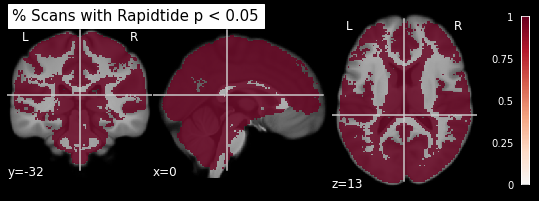

In [7]:
%matplotlib inline
t1_bg    = load_img(osp.join(ALL_DIR,'ALL_T1w_restore_brain.nii.gz'))
mask_img = load_img(FINAL_0p050_mask_path)
plot_stat_map(mask_img,t1_bg,alpha=0.8, cmap='RdBu_r', title='% Scans with Rapidtide p < 0.05');

### 4.3 Create Voxel-wise Group-level Lag Map

The steps involved in this calculation are:

1. Concatenate lagmaps for all subjects into a single file (we do this to be able to use 3dTstat in the next step)
2. Compute the nzmean and nzmedian across all subjects' lagmaps
3. Remove voxels that did not reach significance (p<0.05) for at least half the sample.

In [8]:
%%time
FINAL_0p050_lagmap_path = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}.lagtimes_summary.{ss}.nii.gz'.format(pval=p_threshold, ss=scan_selection))
aux_output1_path        = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}_all.{ss}.nii.gz'.format(pval=p_threshold, ss=scan_selection))
aux_output2_path        = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}.lagtimes_summary_nomask.{ss}.nii.gz'.format(pval=p_threshold, ss=scan_selection))
command                 = 'module load afni; \
                           echo "++ INFO: Combine all lag maps from all subjects into a single file"; \
                           echo "   ==============================================================="; \
                           3dTcat  -overwrite -prefix {output_1} {input_files}; \
                           echo "++ INFO: Compute basic statistics across subjects" ; \
                           echo "   =============================================="; \
                           3dTstat -overwrite -nzmean -nzmedian -mean -median -prefix {output_2} {output_1}; \
                           echo "++ INFO: Restrict group maps to voxels that were significant in at least half the sample"; \
                           echo "   ====================================================================================="; \
                           3dcalc  -overwrite -a {output_2} -b {mask} -expr "a*b" -prefix {output_3}; rm {output_1}; \
                           echo "++ INFO: Trick to avoid issue regarding 5th dimension in nilearn"; \
                           echo "   ============================================================="; \
                           3dTcat -overwrite -prefix {output_3} {output_3};'.format(output_1=aux_output1_path,
                                                                                                                                output_2   = aux_output2_path,
                                                                                                                                output_3   = FINAL_0p050_lagmap_path,
                                                                                                                                mask       = FINAL_0p050_mask_path,
                                                                                                                                input_files= ' '.join(masked_lagtimes))
output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())
print('++ INFO: Final significance mask for rapidtide (p<0.05) --> %s' % FINAL_0p050_lagmap_path)

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18

++ INFO: Combine all lag maps from all subjects into a single file
++ 3dTcat: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
*+ WARNING: Set TR of output dataset to 1.0 s
++ elapsed time = 26.9 s
++ INFO: Compute basic statistics across subjects
++ 3dTstat: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
++ Authored by: KR Hammett & RW Cox
++ Warning: 1281890 bad floats computed in MAKER_4D_to_typed_fbuc
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary_nomask.all.nii.gz
++ INFO: Restrict group maps to voxels that were significant in at least half the sample
++ 3dcalc: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.all.nii.gz
++ INFO: Trick to avoid issue regarding 5th dimension in nilearn
++ 3dTcat: AFNI version

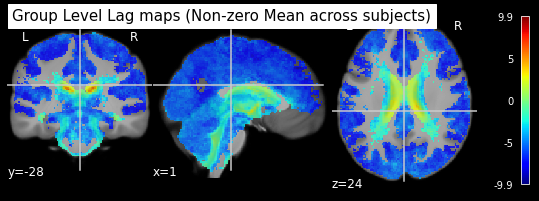

In [9]:
lagmap_img = load_img(index_img(FINAL_0p050_lagmap_path,0))
plot_stat_map(lagmap_img,t1_bg,alpha=0.8, cmap='jet', title='Group Level Lag maps (Non-zero Mean across subjects)');

In [10]:
FINAL_0p050_lagmap_path = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}.lagtimes_summary.{ss}.nii.gz'.format(pval='0p050',ss=scan_selection))
print('++ INFO: Final significance map for rapidtide (p<0.05)          --> %s' % FINAL_0p050_mask_path)
print('++ INFO: Final average lagtime map across all subjects (p<0.05) --> %s' % FINAL_0p050_lagmap_path)

++ INFO: Final significance map for rapidtide (p<0.05)          --> /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050_mask.all.nii.gz
++ INFO: Final average lagtime map across all subjects (p<0.05) --> /data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.all.nii.gz


In [18]:
text="""
Now, we can create images of delay maps using afni, as follows:

```bash
module load afni

cd /data/SFIMJGC_HCP7T/HCP7T/ALL

afni -DAFNI_IMAGE_LABEL_MODE=1 -DAFNI_IMAGE_LABEL_SIZE=4 \\
-com "OPEN_WINDOW A.axialimage mont=10x1:18" -com "CLOSE_WINDOW A.coronalimage" \\
-com "SWITCH_UNDERLAY T1w_restore_brain.MEAN.abox.nii.gz" \\
-com "SWITCH_OVERLAY ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.all.nii.gz" \\
-com "SET_SUBBRICKS A 0 1 1" -com "SET_PBAR_ALL A.-99 9 GoogleTurbo" -com "SET_XHAIRS A.OFF" \\
-com "OPEN_WINDOW A.sagittalimage mont=7x1:24" \\
-com "SAVE_PNG A.axialimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/figures/Revision1_Figure12_PanelA_Axial.{ss}.png" \\
-com "SAVE_PNG A.sagittalimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/figures/Revision1_Figure12_PanelA_Sagittal.{ss}.png" -com "QUITT"
```
""".format(ss=scan_selection)
md("%s"%(text))


Now, we can create images of delay maps using afni, as follows:

```bash
module load afni

cd /data/SFIMJGC_HCP7T/HCP7T/ALL

afni -DAFNI_IMAGE_LABEL_MODE=1 -DAFNI_IMAGE_LABEL_SIZE=4 \
-com "OPEN_WINDOW A.axialimage mont=10x1:18" -com "CLOSE_WINDOW A.coronalimage" \
-com "SWITCH_UNDERLAY T1w_restore_brain.MEAN.abox.nii.gz" \
-com "SWITCH_OVERLAY ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.all.nii.gz" \
-com "SET_SUBBRICKS A 0 1 1" -com "SET_PBAR_ALL A.-99 9 GoogleTurbo" -com "SET_XHAIRS A.OFF" \
-com "OPEN_WINDOW A.sagittalimage mont=7x1:24" \
-com "SAVE_PNG A.axialimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/figures/Revision1_Figure12_PanelA_Axial.all.png" \
-com "SAVE_PNG A.sagittalimage /data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/figures/Revision1_Figure12_PanelA_Sagittal.all.png" -com "QUITT"
```


Column
    [0] PNG(str)
    [1] PNG(str)
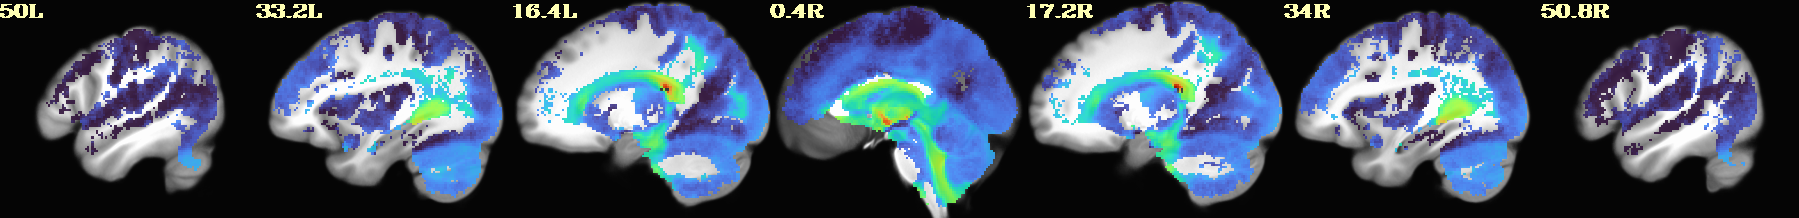
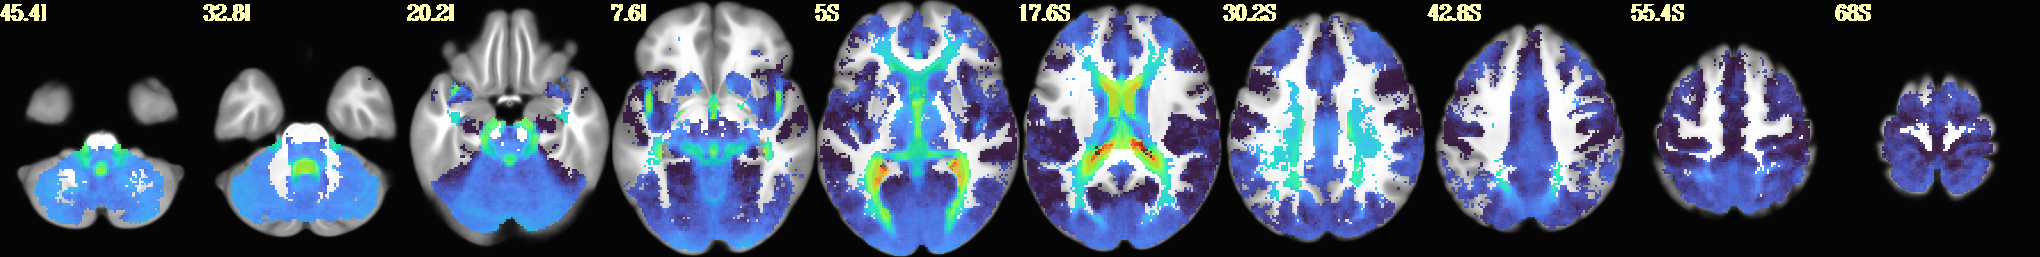

In [22]:
pn.Column(pn.pane.PNG('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/figures/Revision1_Figure12_PanelA_Axial.{ss}.png'.format(ss=scan_selection)),
          pn.pane.PNG('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep/Notebooks/figures/Revision1_Figure12_PanelA_Sagittal.{ss}.png'.format(ss=scan_selection)))

Above we generated 4 different types of average lag maps--namely mean, median, non-zero mean and non-zero median. In the paper we report the non-zero median case. To make that clear, we now generate a new
file that only contains that map.

In [44]:
command = "module load afni; \
               cd /data/SFIMJGC_HCP7T/HCP7T/ALL; \
               3dcalc -overwrite -a ALL.rapidtide_BASICnobpf_p_lt_{pval}.lagtimes_summary.{ss}.nii.gz[1] -expr 'a' -prefix Revision1_Figure12_LagMaps.{ss}.nii.gz".format(pval=pval,ss=scan_selection)

output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18

++ 3dcalc: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./Revision1_Figure12_LagMaps.all.nii.gz


### Create Histogram of Delays across the whole brain

In [45]:
# Paths to the mask and lagtimes
hist_mask_path = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_0p050_mask.{ss}.nii.gz'.format(ss=scan_selection))
hist_lags_path = osp.join(DATA_DIR,'ALL','Revision1_Figure12_LagMaps.{ss}.nii.gz'.format(ss=scan_selection))

In [46]:
# Load all lagtimes into a single dataframe (index = voxels)
lags_across_brain = pd.DataFrame(apply_mask(hist_lags_path,hist_mask_path), columns=['Lag [seconds]'])

In [60]:
fontsize_opts={'xlabel':18,'ylabel':18,'xticks':16,'yticks':16}
(lags_across_brain.hvplot.hist(normed=True, bins=30, c='gray', width=500, height=500) * lags_across_brain.hvplot.kde(fontsize=fontsize_opts, ylabel='Density [proportion of voxels]', c='gray')).opts(toolbar=None)

:Overlay
   .Histogram.I    :Histogram   [Lag [seconds]]   (Lag [seconds]_frequency)
   .Distribution.I :Distribution   [Lag [seconds]]   (Density)

In [68]:
print('++ INFO: Lag Range in the brain (5th to 95th quantiles) = [%.2f sec, %.2f sec]' % (lags_across_brain.quantile(0.05), lags_across_brain.quantile(0.95)))
print('++ INFO: Lag Range in the brain (min to max values)     = [%.2f sec, %.2f sec]' % (lags_across_brain.min(), lags_across_brain.max()))

++ INFO: Lag Range in the brain (5th to 95th quantiles) = [-9.15 sec, -2.33 sec]
++ INFO: Lag Range in the brain (min to max values)     = [-11.04 sec, 9.28 sec]


### Histograms for specific regions (supplementary figure 5)

First, we bring the Eickhoff SB et al. atlas provided by AFNI into the same grid as our group results:

```bash
module load afni
cd /data/SFIMJGC_HCP7T/HCPt7T/ALL
3dcopy /usr/local/apps/afni/current/linux_centos_7_64/MNI_caez_mpm_22+tlrc. MNI_caez_mpm_22.nii.gz
3dresample -input MNI_caez_mpm_22.nii.gz -rmode NN -master ALL_ROI.V4lt.mPP.nii.gz -prefix MNI_caez_mpm_22.nii.gz
3drefit -copytables /usr/local/apps/afni/current/linux_centos_7_64/MNI_caez_mpm_22+tlrc. MNI_caez_mpm_22.nii.gz

3dcopy /usr/local/apps/afni/current/linux_centos_7_64/MNI_caez_ml_18+tlrc. MNI_caez_ml_18.nii.gz
3dresample -input MNI_caez_ml_18.nii.gz -rmode NN -master ALL_ROI.V4lt.mPP.nii.gz -prefix MNI_caez_ml_18.nii.gz
3drefit -copytables /usr/local/apps/afni/current/linux_centos_7_64/MNI_caez_ml_18+tlrc. MNI_caez_ml_18.nii.gz
```

Next we extract three ROIs of interest:

```bash
3dcalc -a MNI_caez_mpm_22.nii.gz -expr 'equals(a,181) + equals(a,210) + equals(a,213) + equals(a,218)' -prefix MNI_caez_mpm_22.Auditory.nii.gz
3dcalc -a MNI_caez_ml_18.nii.gz -expr 'equals(a,57) + equals(a,58)' -prefix MNI_caez_ml_18.Somatosensory.nii.gz
3dcalc -a MNI_caez_ml_18.nii.gz -expr 'equals(a,7) + equals(a,8) + equals(a,3) + equals(a,4) + within(a,11,16)' -prefix MNI_caez_ml_18.Frontal.nii.gz
```

Finally, we write into a text file all the lag values (different from zero) for voxels in each of the ROIs:

```bash
3dmaskdump -nozero -noijk -mask MNI_caez_mpm_22.Auditory.nii.gz ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.all.nii.gz[1] >> Lags_in_Auditory.1D
3dmaskdump -nozero -noijk -mask MNI_caez_ml_18.Somatosensory.nii.gz     ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.all.nii.gz[1] >> Lags_in_Somatosensory.1D
3dmaskdump -nozero -noijk -mask MNI_caez_ml_18.Frontal.nii.gz   ALL.rapidtide_BASICnobpf_p_lt_0p050.lagtimes_summary.all.nii.gz[1] >> Lags_in_Frontal.1D

```


In [77]:
lags_ss = pd.DataFrame(np.loadtxt(osp.join(DATA_DIR,'ALL','Lags_in_Somatosensory.1D')))
lags_au = pd.DataFrame(np.loadtxt(osp.join(DATA_DIR,'ALL','Lags_in_Auditory.1D')))
lags_fr = pd.DataFrame(np.loadtxt(osp.join(DATA_DIR,'ALL','Lags_in_Frontal.1D')))

In [91]:
fontsize_opts={'xlabel':18,'ylabel':18,'xticks':16,'yticks':16,'legend':16,'legend_title':16,'title':16}
(lags_ss.hvplot.kde(label='Somatosensory Cortex', c='r', fontsize=fontsize_opts, ylabel='Densisty\n[proportion of voxels]', xlabel='Lags [seconds]') * \
lags_au.hvplot.kde(label='Auditory Cortex', c='orange') * \
lags_fr.hvplot.kde(label='Frontal Cortex', c='blue')).opts(toolbar=None)

:Overlay
   .Distribution.Somatosensory_Cortex :Distribution   [0]   (Density)
   .Distribution.Auditory_Cortex      :Distribution   [0]   (Density)
   .Distribution.Frontal_Cortex       :Distribution   [0]   (Density)

***

# 5. Generation of Group-level Cross-Correlation traces

For each lag, we compute the average across all subjects of the cross-correlation traces for that particular lag. For each voxel, we only use data from subjects for which that particular voxel was significant according to rapidtide.

In [29]:
pval = '0p050'

In [33]:
%%time
nvols=31
# First we need to do this on a sub-brick by sub-brick fashion, then we will put them together with 
# 3dTcat or 3dTbucket
# =================================================================================================
for pval in ['0p050']:
    print('++++++++++++ ----------------------- %s ---------------------- ++++++++++++' % (pval))
    for v in np.arange(nvols):
        print(v,end='..')
        input_files  = ' '.join([file+'[{v}]'.format(v=v) for file in masked_corrout])
        output1_path = osp.join(DATA_DIR,'ALL','rm.ALL.rapidtide_BASICnobpf_p_lt_{pval}_all.v{v}.{ss}.nii.gz'.format(pval=pval,v=str(v).zfill(2),ss=scan_selection))
        output2_path = osp.join(DATA_DIR,'ALL','rm.ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.v{v}.{ss}.nii.gz'.format(pval=pval,v=str(v).zfill(2),ss=scan_selection))
        mask_path    = osp.join(DATA_DIR,'ALL','ALL.rapidtide_BASICnobpf_p_lt_{pval}_mask.{ss}.nii.gz'.format(pval=pval,ss=scan_selection))
        command = 'module load afni;                                                            \
               3dTcat -overwrite -prefix {output_1} {input_files};                              \
               3dcalc -overwrite -a {output_1} -expr "atanh(a)" -prefix  {output_1};             \
               3dTstat -overwrite -nzmean -prefix {output_2} {output_1};                         \
               3dcalc -overwrite -a {output_2} -expr "tanh(a)" -prefix {output_2};               \
               3dcalc -overwrite \
                      -a {output_2} \
                      -b {mask} \
                      -expr "a*b" \
                      -prefix {output_2}; \
              rm {output_1}'.format(output_1=output1_path,
                                    output_2=output2_path,
                                    mask=mask_path,
                                    input_files=input_files)
        output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        print(output.strip().decode())

++++++++++++ ----------------------- 0p050 ---------------------- ++++++++++++
0..[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-17

++ 3dTcat: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
++ elapsed time = 196.0 s
++ 3dcalc: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/rm.ALL.rapidtide_BASICnobpf_p_lt_0p050_all.v00.all.nii.gz
++ 3dTstat: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
++ Authored by: KR Hammett & RW Cox
++ Warning: 1281890 bad floats computed in MAKER_4D_to_typed_fbuc
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/rm.ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.v00.all.nii.gz
++ 3dcalc: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_HCP7T/HCP7T/ALL/rm.ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.v00.all.nii.gz
++ 3dcalc: AFNI version=AFNI_22.0.20 (Mar 15 2022)

We now put together the results from the previous cell into a single file with all the datapoints. This code sets the time origin to -15s (which is what the original corrout datasets had). As TR is 1s, this does not need fixing as of now --> it might if you take out the -O 1 from rapidtide and or the data has a different TR


In [34]:
%%time
if not osp.exists('/data/SFIMJGC_HCP7T/HCP7T/ALL/temp_lag_results'):
    os.mkdir('/data/SFIMJGC_HCP7T/HCP7T/ALL/temp_lag_results')
    print("++ INFO: Temporary folder created: /data/SFIMJGC_HCP7T/HCP7T/ALL/temp_lag_results")

command = 'module load afni; \
               cd /data/SFIMJGC_HCP7T/HCP7T/ALL; \
               3dTcat -overwrite -prefix ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.{ss}.nii.gz   rm.ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.v??.{ss}.nii.gz[0]; \
               3drefit -Torg -15 ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.{ss}.nii.gz; \
               mv rm.ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.v??.{ss}.nii.gz temp_lag_results'.format(pval=pval,ss=scan_selection)
output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())
print('============================================================================')
print('++ INFO: Output file: ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.{ss}.nii.gz'.format(pval=pval, ss=scan_selection))

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18

++ 3dTcat: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
*+ WARNING: Set TR of output dataset to 1.0 s
++ elapsed time = 4.1 s
++ 3drefit: AFNI version=AFNI_22.0.20 (Mar 15 2022) [64-bit]
++ Authored by: RW Cox
++ Processing AFNI dataset ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.all.nii.gz
 + changing Torg
 + loading and re-writing dataset ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.all.nii.gz (/gpfs/gsfs9/users/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.all.nii.gz in NIFTI storage)
++ 3drefit processed 1 datasets
++ INFO: Output file: ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.all.nii.gz
CPU times: user 3.81 ms, sys: 15.3 ms, total: 19.1 ms
Wall time: 8.03 s


***

# 6. Show cross-correlation traces for a few represntative voxels (those will be in a manuscript figure)


In [23]:
ijk_locs = [(56,52,24),(64,55,54),(64,97,46),(48,27,49),(33,65,56),(42,62,80)]
for i,j,k in ijk_locs:
    command = "module load afni; \
               cd /data/SFIMJGC_HCP7T/HCP7T/ALL; \
               3dmaskdump -quiet -noijk -ibox {i} {j} {k} ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.{ss}.nii.gz | tr -s ' ' '\n' > LagProfile_I{i}_J{j}_K{k}.{ss}.1D".format(i=i,j=j,k=k, ss=scan_selection)
    output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
    print(output.strip().decode())

command = 'module load afni; \
           cd /data/SFIMJGC_HCP7T/HCP7T/ALL; \
           3dROIstats -quiet -mask {mask} ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.{ss}.nii.gz > ALL.rapidtide_BASICnobpf_p_lt_{pval}.corrout_summary.nzmean.{ss}.1D'.format(mask=FINAL_0p050_mask_path,pval=p_threshold, ss=scan_selection)
output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())                                    

[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18
[+] Loading AFNI current-openmp  ... 
AFNI/current-openmp last updated  2022-03-18


In [24]:
location_labels = ['Whole Brain', '(1) 4th Vent.', '(2) Post. Lat. Vent.', '(3) Ant. Lat. Vent.', '(4) PVC',     '(5) PAC',     '(6) PMC']
location_prefix = ['WB',          'I56_J52_K24',   'I64_J55_K54',          'I64_J97_K46',         'I48_J27_K49', 'I33_J65_K56', 'I42_J62_K80']
n_plots         = len(location_prefix)
data_dict={}
data = None
for i in np.arange(n_plots):
    if i == 0:
        path = '/data/SFIMJGC_HCP7T/HCP7T/ALL/ALL.rapidtide_BASICnobpf_p_lt_0p050.corrout_summary.nzmean.{ss}.1D'.format(ss=scan_selection)
    else:
        path = '/data/SFIMJGC_HCP7T/HCP7T/ALL/LagProfile_{ii}.{ss}.1D'.format(ii=location_prefix[i],ss=scan_selection)
    df   = pd.DataFrame(np.loadtxt(path)).reset_index()
    df.columns=['Lag (s)','Cross-Correlation']
    df['Lag (s)'] = df['Lag (s)'] - 15
    df['Location'] = location_labels[i]
    if data is None:
        data = df
    else:
        data = pd.concat([data,df],axis=0)
    data_dict[location_labels[i]] = df

In [25]:
data.groupby('Location').min()

Lag (s)  Cross-Correlation
Location                                        
(1) 4th Vent.             -15          -0.208279
(2) Post. Lat. Vent.      -15          -0.117433
(3) Ant. Lat. Vent.       -15          -0.205822
(4) PVC                   -15          -0.316295
(5) PAC                   -15          -0.417238
(6) PMC                   -15          -0.425084
Whole Brain               -15          -0.248060

In [26]:
plots = None
for i in np.arange(n_plots):
    if plots is None:
        plots = data_dict[location_labels[i]].hvplot(x='Lag (s)', width=200, height=250, c='b', ylim=(-0.5,1), title=location_labels[i], grid=True).opts(toolbar=None)
    else:
        plots = plots + data_dict[location_labels[i]].hvplot(x='Lag (s)', width=200, height=250, c='k', title=location_labels[i], grid=True).opts(toolbar=None)

In [27]:
fig8_panelsBC = plots.cols(7).opts(toolbar=None)
fig8_panelsBC

:Layout
   .Curve.I   :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.II  :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.III :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.IV  :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.V   :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.VI  :Curve   [Lag (s)]   (Cross-Correlation)
   .Curve.VII :Curve   [Lag (s)]   (Cross-Correlation)

In [31]:
lagmap_path       = osp.join(ALL_DIR,'Figure8_LagMaps.{ss}.nii.gz'.format(ss=scan_selection))
lagmap_img        = load_img(lagmap_path)

In [32]:
fig, axs = plt.subplots(2,1,figsize=(20,7))
fig8_panelAsag = plot_stat_map(lagmap_img,t1_bg,cmap='jet', vmax=9, display_mode='x', axes=axs[1], cut_coords=[-53,-35,-18,0,18,35,53])
fig8_panelAaxi = plot_stat_map(lagmap_img,t1_bg,cmap='jet', vmax=9, display_mode='z', axes=axs[0], cut_coords=[-45,-32,-19,-7,6,19,31,44,56,68])
fig.suptitle('(A) Temporal Lag Maps', fontsize=20, fontweight='bold')
plt.close()

In [33]:
fig8 = pn.Column(pn.pane.Matplotlib(fig),pn.pane.Markdown('# (B) Whole Brain      (C) Voxel-wise cross-correlations for representative locations indicated above'),pn.pane.HoloViews(fig8_panelsBC))

In [34]:
fig8.save('./figures/Fig08_RapidTide_results.{ss}.png'.format(ss=scan_selection))

In [35]:
text="![](./figures/Fig08_RapidTide_results.{ss}.png)".format(ss=scan_selection)
md("%s"%(text))

![](./figures/Fig08_RapidTide_results.all.png)

In [12]:
a=pd.read_csv(osp.join(DATA_DIR,'ALL','a.txt'),sep='\t')

In [47]:
b=pd.read_csv(osp.join(DATA_DIR,'ALL','b.txt'),sep='\t')

In [70]:
c=pd.read_csv(osp.join(DATA_DIR,'ALL','c.txt'),sep='\t')

In [74]:
c[[col for col in c.columns if 'Central' in col]]

Empty DataFrame
Columns: []
Index: [0]

In [61]:
[c for c in b.columns if 'Frontal' in c]

['Mean_Left Superior Frontal Gyrus  ',
 'Mean_Right Superior Frontal Gyrus  ',
 'Mean_Left Middle Frontal Gyrus  ',
 'Mean_Right Middle Frontal Gyrus  ',
 'Mean_Left Inferior Frontal Gyrus (p. Opercularis)  ',
 'Mean_Right Inferior Frontal Gyrus (p. Opercularis)  ',
 'Mean_Left Inferior Frontal Gyrus (p. Triangularis)  ',
 'Mean_Right Inferior Frontal Gyrus (p. Triangularis)  ',
 'Mean_Left Inferior Frontal Gyrus (p. Orbitalis)  ',
 'Mean_Right Inferior Frontal Gyrus (p. Orbitalis)  ']

In [16]:
a[['NZMean_Left Calcarine Gyrus', 'NZMean_Right Calcarine Gyrus','NZMean_Left Thalamus', 'NZMean_Right Thalamus','NZMean_Left Cerebellum (Crus 1)',
 'NZMean_Right Cerebellum (Crus 1)',
 'NZMean_Left Cerebellum (Crus 2)',
 'NZMean_Right Cerebellum (Crus 2)',
 'NZMean_Left Cerebellum (III)',
 'NZMean_Right Cerebellum (III)',
 'NZMean_Left Cerebellum (IV-V)',
 'NZMean_Right Cerebellum (IV-V)',
 'NZMean_Left Cerebellum (VI)',
 'NZMean_Right Cerebellum (VI)',
 'NZMean_Left Cerebellum (VII)',
 'NZMean_Right Cerebellum (VII)',
 'NZMean_Left Cerebellum (VIII)',
 'NZMean_Right Cerebellum (VIII)',
 'NZMean_Left Cerebellum (IX)',
 'NZMean_Right Cerebellum (IX)',
 'NZMean_Left Cerebellum (X)',
 'NZMean_Right Cerebellum (X)']]

NZMean_Left Calcarine Gyrus  NZMean_Right Calcarine Gyrus  \
0                     -5.64382                     -5.350148   

   NZMean_Left Thalamus  NZMean_Right Thalamus  \
0             -3.988663              -3.999916   

   NZMean_Left Cerebellum (Crus 1)  NZMean_Right Cerebellum (Crus 1)  \
0                        -4.893656                         -4.863325   

   NZMean_Left Cerebellum (Crus 2)  NZMean_Right Cerebellum (Crus 2)  \
0                        -5.031558                         -5.024804   

   NZMean_Left Cerebellum (III)  NZMean_Right Cerebellum (III)  ...  \
0                      -4.27506                      -4.228317  ...   

   NZMean_Left Cerebellum (VI)  NZMean_Right Cerebellum (VI)  \
0                    -5.389583                     -5.436606   

   NZMean_Left Cerebellum (VII)  NZMean_Right Cerebellum (VII)  \
0                     -5.121932                      -5.003894   

   NZMean_Left Cerebellum (VIII)  NZMean_Right Cerebellum (VIII)  \
0                       -5.51616                        -5.47965   

   NZMean_Left Cerebellum (IX)  NZMean_Right Cerebellum (IX)  \
0                    -4.160174                     -4.730582   

   NZMean_Left Cerebellum (X)  NZMean_Right Cerebellum (X)  
0                   -4.079313                    -4.548065  

[1 rows x 22 columns]

In [37]:
vis_delay = a[['NZMean_Left Calcarine Gyrus', 'NZMean_Right Calcarine Gyrus']].median(axis=1).values[0]

In [38]:
mot_delay = a[['NZMean_Left Postcentral Gyrus', 'NZMean_Right Postcentral Gyrus']].median(axis=1).values[0]

In [39]:
thal_delay = a[['NZMean_Left Thalamus', 'NZMean_Right Thalamus']].median(axis=1).values[0]

In [40]:
cere_delay = a[['NZMean_Left Cerebellum (Crus 1)','NZMean_Right Cerebellum (Crus 1)','NZMean_Left Cerebellum (Crus 2)','NZMean_Right Cerebellum (Crus 2)','NZMean_Left Cerebellum (III)','NZMean_Right Cerebellum (III)','NZMean_Left Cerebellum (IV-V)','NZMean_Right Cerebellum (IV-V)',
 'NZMean_Left Cerebellum (VI)','NZMean_Right Cerebellum (VI)','NZMean_Left Cerebellum (VII)','NZMean_Right Cerebellum (VII)','NZMean_Left Cerebellum (VIII)','NZMean_Right Cerebellum (VIII)','NZMean_Left Cerebellum (IX)','NZMean_Right Cerebellum (IX)','NZMean_Left Cerebellum (X)','NZMean_Right Cerebellum (X)']].median(axis=1).values[0]

In [41]:
print(vis_delay,mot_delay,thal_delay,cere_delay)

-5.496983999999999 -6.5195685 -3.9942895 -5.014348999999999


In [30]:
thal     = pd.read_csv(osp.join(DATA_DIR,'ALL','Thalamus_lags.1D'),header=None)
thal_vis = pd.read_csv(osp.join(DATA_DIR,'ALL','Thalamus_Visual_lags.1D'),header=None)
thal_ss  = pd.read_csv(osp.join(DATA_DIR,'ALL','Thalamus_SS_lags.1D'),header=None)
vis      = pd.read_csv(osp.join(DATA_DIR,'ALL','Visual_lags.1D'),header=None)
motor    = pd.read_csv(osp.join(DATA_DIR,'ALL','Motor_lags.1D'),header=None)
aud      = pd.read_csv(osp.join(DATA_DIR,'ALL','Auditory_lags.1D'),header=None)

cer      = pd.read_csv(osp.join(DATA_DIR,'ALL','Cerebellum_lags.1D'),header=None)
frontal  = pd.read_csv(osp.join(DATA_DIR,'ALL','Frontal_lags.1D'),header=None)

In [32]:
aud.hvplot.kde(label='Auditory') * motor.hvplot.kde(label='Motor') * frontal.hvplot.kde(label='Frontal')

:Overlay
   .Distribution.Auditory :Distribution   [0]   (Density)
   .Distribution.Motor    :Distribution   [0]   (Density)
   .Distribution.Frontal  :Distribution   [0]   (Density)

In [75]:
thal_vis.hvplot.kde(label='Thalamus:Visual') * vis.hvplot.kde(label='Visual') * cer.hvplot.kde(label='Cerebellum')

:Overlay
   .Distribution.Thalamus_colon_Visual :Distribution   [0]   (Density)
   .Distribution.Visual                :Distribution   [0]   (Density)
   .Distribution.Cerebellum            :Distribution   [0]   (Density)

In [71]:
thal_vis.hvplot.kde(label='Thalamus:Visual') * thal_ss.hvplot.kde(label='Thalamus:SS') * vis.hvplot.kde(label='Visual') * cer.hvplot.kde(label='Cerebellum') * motor.hvplot.kde(label='Motor') * frontal.hvplot.kde(label='Frontal')

:Overlay
   .Distribution.Thalamus_colon_Visual :Distribution   [0]   (Density)
   .Distribution.Thalamus_colon_SS     :Distribution   [0]   (Density)
   .Distribution.Visual                :Distribution   [0]   (Density)
   .Distribution.Cerebellum            :Distribution   [0]   (Density)
   .Distribution.Motor                 :Distribution   [0]   (Density)
   .Distribution.Frontal               :Distribution   [0]   (Density)

In [ ]:
3dROIstats -nomeanout -nzmean -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.all.nii.gz > a.txt
  796  18:05  afni
  797  18:13  3dmaskdump -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.
  798  18:13  3dmaskdump -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz 
  799  18:14  3dmaskdump -mrange 77 78 -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz 
  800  18:14  3dmaskdump -noijk -mrange 77 78 -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz 
  801  18:15  3dmaskdump -nozero -noijk -mrange 77 78 -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz 
  802  18:15  3dmaskdump -nozero -noijk -mrange 77 78 -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz > Thalamus_lags.1D
  803  18:17  3dmaskdump -nozero -noijk -mrange 43 44 -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz > Visual_lags.1D
  804  18:19  3dROIstats -mask MNI_caez_ml_18.nii.gz MNI_caez_ml_18.nii.gz 
  805  18:20  3dROIstats -mask MNI_caez_ml_18.nii.gz MNI_caez_ml_18.nii.gz > b.txt
  806  18:22  3dmaskdump -nozero -noijk -mrange 91 108 -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz > Cerebellum_lags.1D
  807  18:24  3dmaskdump -nozero -noijk -mrange 57 58 -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz > Motor_lags.1D
  808  18:27  3dmaskdump -nozero -noijk -mrange 3 4 -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz > Frontal_lags.1D
  809  18:27  wc -l Frontal_lags.1D 
  810  18:27  3dmaskdump -nozero -noijk -mrange 7 8 -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz >> Frontal_lags.1D
  811  18:27  wc -l Frontal_lags.1D 
  812  18:28  3dmaskdump -nozero -noijk -mrange 11 16 -mask MNI_caez_ml_18.nii.gz Figure8_LagMaps.nii.gz >> Frontal_lags.1D
  813  18:35  history
